# [CNN Transference](https://github.com/kokchun/Deep-learning-AI21/blob/main/Lectures/Lec5-Transfer_learning_CNN.ipynb)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds

(train, test), info = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True,
)

info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/Users/creativezone/tensorflow_datasets/tf_flowers/3.0.1',
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [18]:
labels_names = [
    "dandelion",
    "daisy",
    "tulips",
    "sunflowers",
    "roses",
]

In [10]:
type(train), train

(tensorflow.python.data.ops.dataset_ops.PrefetchDataset,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

img_sample[0].shape=TensorShape([333, 500, 3]), label:img_sample[1]=<tf.Tensor: shape=(), dtype=int64, numpy=2>
img_sample[0].shape=TensorShape([212, 320, 3]), label:img_sample[1]=<tf.Tensor: shape=(), dtype=int64, numpy=3>
img_sample[0].shape=TensorShape([240, 320, 3]), label:img_sample[1]=<tf.Tensor: shape=(), dtype=int64, numpy=3>
img_sample[0].shape=TensorShape([240, 320, 3]), label:img_sample[1]=<tf.Tensor: shape=(), dtype=int64, numpy=4>
img_sample[0].shape=TensorShape([317, 500, 3]), label:img_sample[1]=<tf.Tensor: shape=(), dtype=int64, numpy=3>
img_sample[0].shape=TensorShape([212, 320, 3]), label:img_sample[1]=<tf.Tensor: shape=(), dtype=int64, numpy=0>
img_sample[0].shape=TensorShape([240, 240, 3]), label:img_sample[1]=<tf.Tensor: shape=(), dtype=int64, numpy=0>
img_sample[0].shape=TensorShape([333, 500, 3]), label:img_sample[1]=<tf.Tensor: shape=(), dtype=int64, numpy=0>


2022-05-04 10:19:11.386124: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


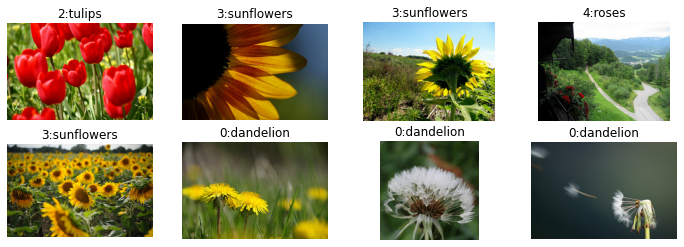

In [19]:
fig, axes = plt.subplots(2,4,figsize=(12,4))

for i, img_sample in enumerate(train.take(8)):
    print(f'{img_sample[0].shape=}, label:{img_sample[1]=}')
    ax = axes.flatten()[i]
    ax.imshow(img_sample[0])
    ax.set_title(f'{img_sample[1]}:{labels_names[img_sample[1]]}')
    ax.axis("off")

## Preprocessing

In [21]:
def preprocessing(image, label, image_shape=(120,120)):
    return tf.image.resize(image ,image_shape) / 255.0, label

input_shape = (120, 120, 3)
batch_size = 32

train_batch = train.shuffle(buffer_size=600).map(preprocessing).batch(batch_size).prefetch(1)
test_batch = test.map(preprocessing).batch(batch_size).prefetch(1)

train_batch

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Transfer learning

In [22]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.summary()

58900480/58889256 [==============================] - 18s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                             

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

model = Sequential([
    base_model,
    Flatten(),
    Dropout(.5),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dropout(.5),
    Dense(5, activation='softmax')
], name='bert')

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "bert"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 4608)              0         
                                                                 
 dropout_4 (Dropout)         (None, 4608)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               1179904   
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 15,895,877
Trainable params: 1,181,189
Non-train

In [27]:
model.fit(train_batch, epochs=20, validation_data=test_batch)

Epoch 1/20
 1/92 [..............................] - ETA: 38s - loss: 2.2399 - acc: 0.1562

2022-05-04 11:06:34.636524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - ETA: 0s - loss: 1.2220 - acc: 0.5412

2022-05-04 11:06:42.440875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 10s 104ms/step - loss: 1.2220 - acc: 0.5412 - val_loss: 0.7731 - val_acc: 0.7193
Epoch 2/20
92/92 [==============================] - 9s 103ms/step - loss: 0.8320 - acc: 0.6911 - val_loss: 0.6892 - val_acc: 0.7534
Epoch 3/20
92/92 [==============================] - 9s 102ms/step - loss: 0.7047 - acc: 0.7503 - val_loss: 0.6302 - val_acc: 0.7943
Epoch 4/20
92/92 [==============================] - 9s 103ms/step - loss: 0.6264 - acc: 0.7718 - val_loss: 0.6209 - val_acc: 0.7793
Epoch 5/20
92/92 [==============================] - 9s 102ms/step - loss: 0.5565 - acc: 0.7943 - val_loss: 0.6124 - val_acc: 0.7916
Epoch 6/20
92/92 [==============================] - 9s 103ms/step - loss: 0.5100 - acc: 0.8151 - val_loss: 0.6072 - val_acc: 0.7834
Epoch 7/20
92/92 [==============================] - 9s 102ms/step - loss: 0.4664 - acc: 0.8324 - val_loss: 0.6294 - val_acc: 0.7793
Epoch 8/20
92/92 [==============================] - 9s 103ms/step - loss: 0.4273 - acc

In [28]:
metrics = pd.DataFrame(model.history.history)
metrics.head(1)

,loss,acc,val_loss,val_acc
0,1.221982,0.541212,0.77308,0.719346


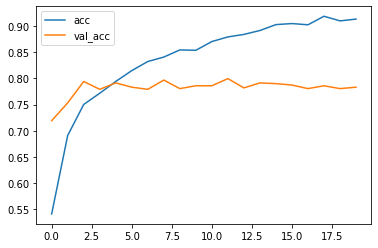

In [40]:
metrics[['acc', 'val_acc']].plot();

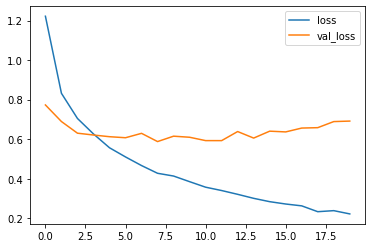

In [41]:
metrics[['loss', 'val_loss']].plot();

## Xception network

In [30]:
from tensorflow.keras.applications import Xception

base_model_2 = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

base_model_2.summary()

83697664/83683744 [==============================] - 3s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 59, 59, 32)   864         ['input_2[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 59, 59, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                          

In [34]:
from tensorflow.keras.layers import GlobalAveragePooling2D

model_2 = Sequential([
    base_model_2,
    GlobalAveragePooling2D(),
    Dropout(.5),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dropout(.5),
    Dense(5, activation='softmax')
], name='big_boi')

for layer in base_model_2.layers:
    layer.trainable = False

model_2.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model_2.summary()

Model: "big_boi"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               524544    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 5)                 1285      
                                                           

In [35]:
model_2.fit(train_batch, epochs=20, validation_data=test_batch)

Epoch 1/20


2022-05-04 11:14:08.819716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - ETA: 0s - loss: 0.9771 - acc: 0.6420

2022-05-04 11:14:18.249205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 12s 107ms/step - loss: 0.9771 - acc: 0.6420 - val_loss: 0.5874 - val_acc: 0.8079
Epoch 2/20
92/92 [==============================] - 9s 101ms/step - loss: 0.6198 - acc: 0.7721 - val_loss: 0.5187 - val_acc: 0.8283
Epoch 3/20
92/92 [==============================] - 9s 99ms/step - loss: 0.5684 - acc: 0.7943 - val_loss: 0.4799 - val_acc: 0.8392
Epoch 4/20
92/92 [==============================] - 9s 98ms/step - loss: 0.4908 - acc: 0.8280 - val_loss: 0.4687 - val_acc: 0.8338
Epoch 5/20
92/92 [==============================] - 9s 99ms/step - loss: 0.4673 - acc: 0.8294 - val_loss: 0.4608 - val_acc: 0.8392
Epoch 6/20
92/92 [==============================] - 9s 99ms/step - loss: 0.4230 - acc: 0.8471 - val_loss: 0.4498 - val_acc: 0.8365
Epoch 7/20
92/92 [==============================] - 9s 98ms/step - loss: 0.4001 - acc: 0.8566 - val_loss: 0.4868 - val_acc: 0.8202
Epoch 8/20
92/92 [==============================] - 9s 99ms/step - loss: 0.3611 - acc: 0.87

In [37]:
metrics_2 = pd.DataFrame(model_2.history.history)

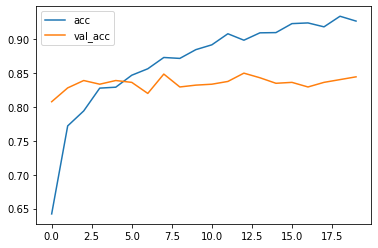

In [39]:
metrics_2[['acc', 'val_acc']].plot();